## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy
from optimization.functions import read_each_loader, convert_sample_2_df, trajectory_estimation

from models.policy_model import RobotPolicy

In [2]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory)

Evaluating Device:  cpu
Current Time:  Jan_31_2024-17_20_40


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)
configs.device = device

Evaluating Device:  cpu


In [4]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [5]:
# load demonstrations dataset
evaluation_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  20
Full Demo Dataset Size:  879


# Functions

In [6]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

# Test

In [7]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Jan_31_2024-17_18_42"

In [8]:
params_name = "policy_network_epoch_100_loss_3_22173.pt"

In [9]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [10]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [11]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [12]:
updater = Updater(configs=configs,
                  policy_network=policy_network)

In [13]:
sample_index = 0

In [14]:
evaluation_sample = evaluation_data[sample_index]

In [15]:
evaluation_sample

(tensor([0.4087, 0.6701, 0.0000, 0.3597]),
 tensor([-0.1683, -0.1799,  0.2758]),
 0,
 0)

In [16]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [17]:
# add a batch dimension by unsqueezing
action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0))

In [18]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [19]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=evaluation_data.state_norms)

In [20]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=evaluation_data.action_norms)[0]

In [21]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=evaluation_data.action_norms)[0]

# Run Through All Samples in a Trajectory for Every Trajectory

In [22]:
# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [23]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

In [24]:
for idx, sample_data in enumerate(evaluation_data):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=sample_data)
    
    # add a batch dimension by unsqueezing
    action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0))
    
    # multivariate Gaussian negative log-likelihood loss function
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=evaluation_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                                   norm_range_list=evaluation_data.action_norms)[0]
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=evaluation_data.action_norms)[0]
    
    # store every important detail in the dataframe
    sample_df = convert_sample_2_df(input_state=input_state,
                                    real_state_input=real_state_input,
                                    output_action=output_action,
                                    real_action_output=real_action_output,
                                    action_log_prob=action_log_prob,
                                    action_pred=action_pred,
                                    action_std=action_std,
                                    real_action_pred=real_action_pred,
                                    trajectory_index=int(trajectory_index),
                                    state_number=int(state_number),
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        df = pd.concat([df, sample_df],
                       ignore_index=True)
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

if len(trajectory_dataframes) == 0:
    trajectory_dataframes.append(df)

In [25]:
trajectory_dataframes[0][["state_label_norm_1", "state_label_norm_2", "state_label_norm_3", "state_label_norm_4",
                          "action_label_norm_1", "action_label_norm_2", "action_label_norm_3",
                          "state_number", "trajectory_index"]]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_norm_4,action_label_norm_1,action_label_norm_2,action_label_norm_3,state_number,trajectory_index
0,0.408677965403,0.670065104961,0.000000000000,0.359723329544,-0.168273642659,-0.179896533489,0.275800764561,0,0
1,0.406743109226,0.669986665249,0.000661581464,0.360050767660,-0.205633714795,-0.153896495700,0.304449856281,1,0
2,0.374670863152,0.664946675301,0.054441925138,0.388699829578,-0.258043706417,-0.132270708680,0.332858413458,2,0
3,0.340508937836,0.669058442116,0.117204912007,0.417108416557,-0.291306763887,-0.110318548977,0.341170072556,3,0
4,0.305450677872,0.662353277206,0.156387746334,0.425420045853,-0.319870948792,-0.043398141861,0.340963006020,4,0
5,0.246377795935,0.619592547417,0.214784890413,0.425213009119,-0.345367670059,0.015027273446,0.343466669321,5,0
6,0.201699137688,0.589209496975,0.272525340319,0.427716672421,-0.357510328293,0.088685438037,0.346270829439,6,0
7,0.169028431177,0.551960527897,0.336605697870,0.430520832539,-0.353839129210,0.170582592487,0.349496304989,7,0
8,0.173597857356,0.514131009579,0.403903335333,0.433746308088,-0.334532320499,0.255132228136,0.349193662405,8,0
9,0.218995034695,0.478141486645,0.471958786249,0.433443665504,-0.284977644682,0.318865031004,0.351500123739,9,0


In [26]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

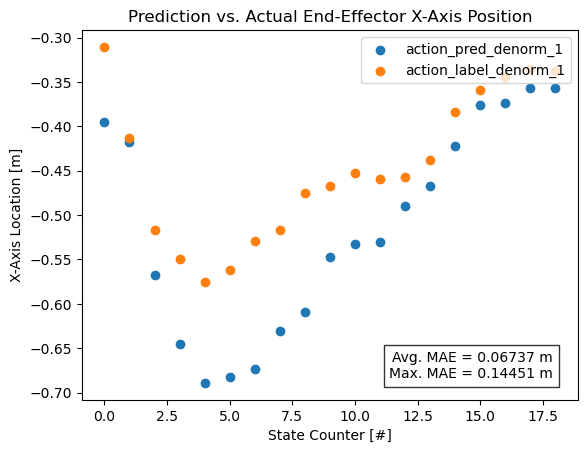

In [27]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

In [28]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_data[0])

In [29]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_data[0])

# index location where the each trajectory starts in the dataframe
traj_start_index = 0

trajectory_estimation(configs=configs,
                      data_loader=evaluation_data,
                      policy_network=policy_network,
                      trajectory_length=constants.TRAJECTORY_SIZE,
                      traj_start_index=traj_start_index)


state_number :  0
initial_state_location :  [-0.33654726 -0.35979307  0.55160141]
action_denorm_label :  [-0.33654726 -0.35979307  0.55160141]
current_state_denorm_estimation :  [0.81735593 1.34013021 0.         0.71944666]
next_state_denorm_label :  [0.81973085 1.3399733  0.         0.72010141]

state_number :  1
initial_state_location :  [-0.33654726 -0.35979307  0.55160141]
action_denorm_label :  [-0.4112674  -0.30779302  0.60889959]
current_state_denorm_estimation :  [0.82237887 1.34035707 0.00659134 0.72467047]
next_state_denorm_label :  [0.86942815 1.32989333 0.1075648  0.77739959]

state_number :  2
initial_state_location :  [-0.33654726 -0.35979307  0.55160141]
action_denorm_label :  [-0.51608741 -0.26454139  0.66571689]
current_state_denorm_estimation :  [0.81521255 1.34034324 0.01157902 0.72983509]
next_state_denorm_label :  [0.96004112 1.33811695 0.23308774 0.83421689]

state_number :  3
initial_state_location :  [-0.33654726 -0.35979307  0.55160141]
action_denorm_label :  

In [30]:
trajectory_dataframes[0][["state_label_denorm_1", "state_label_denorm_2", "state_label_denorm_3", "state_label_denorm_4",
                          "action_label_denorm_1", "action_label_denorm_2", "action_label_denorm_3",
                          "state_number", "trajectory_index"]]

,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,state_number,trajectory_index
0,0.817355930805,1.340130209923,0.000000000000,0.719446659088,-0.336547255516,-0.359793066978,0.551601409912,0,0
1,0.813486218452,1.339973330498,0.001323162927,0.720101535320,-0.411267399788,-0.307793021202,0.608899593353,1,0
2,0.749341726303,1.329893350601,0.108883850276,0.777399659157,-0.516087412834,-0.264541387558,0.665716886520,2,0
3,0.681017875671,1.338116884232,0.234409824014,0.834216833115,-0.582613468170,-0.220637083054,0.682340145111,3,0
4,0.610901355743,1.324706554413,0.312775492668,0.850840091705,-0.639741897583,-0.086796283722,0.681926012039,4,0
5,0.492755591869,1.239185094833,0.429569780827,0.850426018238,-0.690735340118,0.030054569244,0.686933279037,5,0
6,0.403398275375,1.178418993950,0.545050680637,0.855433344841,-0.715020656586,0.177370786667,0.692541599274,6,0
7,0.338056862354,1.103921055794,0.673211395741,0.861041665077,-0.707678318024,0.341165065765,0.698992729187,7,0
8,0.347195714712,1.028262019157,0.807806670666,0.867492616177,-0.669064640999,0.510264396667,0.698387384415,8,0
9,0.437990069389,0.956282973289,0.943917572498,0.866887331009,-0.569955348969,0.637730121613,0.703000307083,9,0
